## SAR and LAM Models Brain Discovery at Different Resolutions 
This notebook focuses on analyzing brain connectivity at different resolution levels (res_parcellation values) and how these affect the functional connectivity (FC) matrices. Using SAR and LAM models, we explore how the connectivity between brain regions changes across varying resolutions. The goal is to identify the best model parameters for each resolution and compare the performance of SAR and LAM models. The analysis includes applying log min-max normalization to the connectivity matrices and determining the optimal parameters that yield the highest correlation. Finally, we dive deeper into the resolution with the best correlation to understand the behavior of the LAM model.

In [23]:
# All the tools you need in this notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from yanat import core as cor
import seaborn as sns
from yanat import utils as ut
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager
from matplotlib import font_manager
from visual_config import *
for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)
set_visual_style()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## This is a multi-resolution connectome and we will analyse the effects of res_parcellation values on the correlations between the modelling matrix and the target matrix. We will observe on the 5 res_parcellation values which are 0, 1, 2, 3 and 4. 

In [24]:
# Same dataset with the analaysis_of_models.ipynb
data = scipy.io.loadmat("human_connectome_dataset/Consensus_Connectomes.mat",  
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,) 

As res_parcellation increases, the degree of division of the brain increases and the size of each region decreases. We can determine which resolution is suitable for our models with the res_parcellation value. 

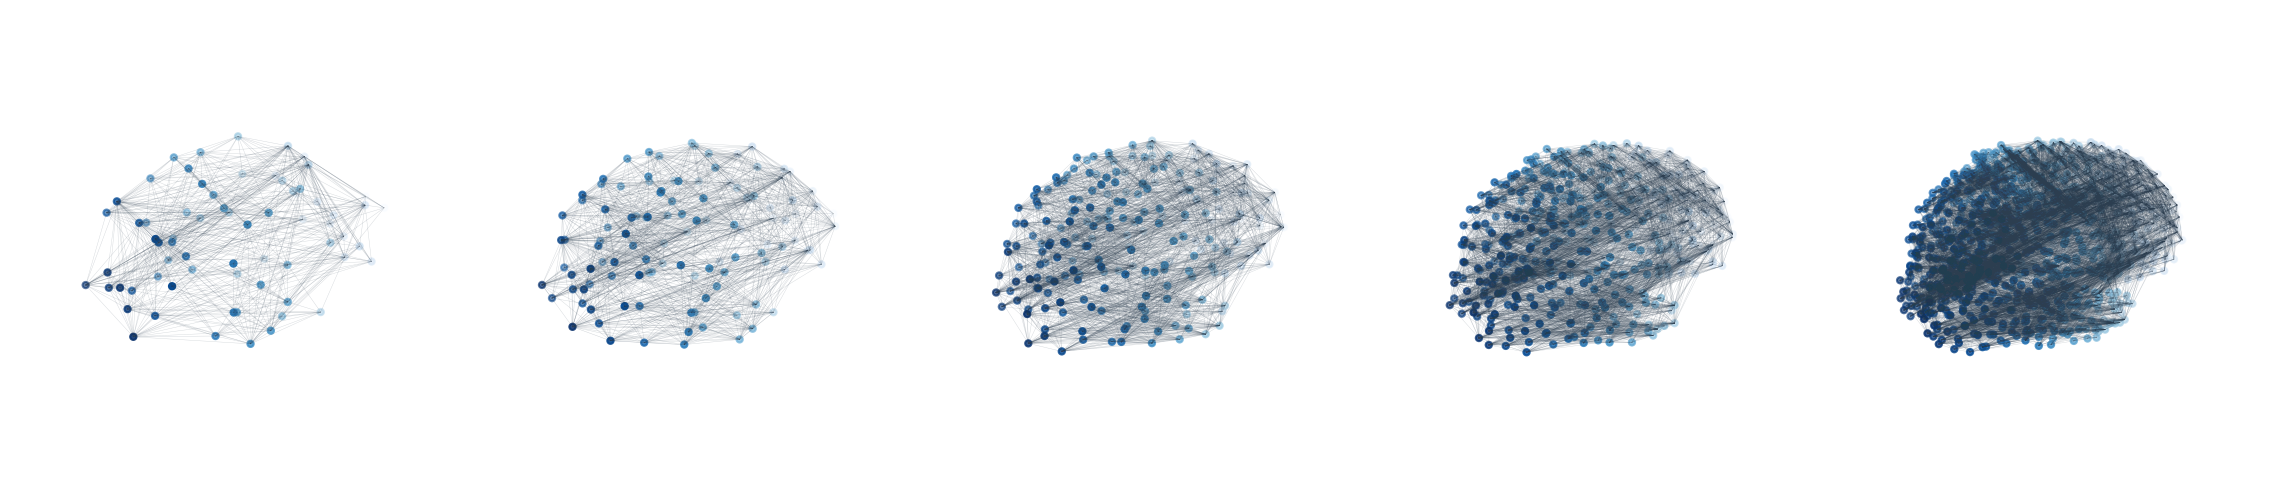

In [25]:
NIGHT_BLUE = "#2c3e50"
monochrome = "Blues"
scatter_kw_network = {}  
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D", "E"]], figsize=(15, 5), subplot_kw=dict(projection="3d"), dpi=150
)
res_parcellation_values = [0, 1, 2, 3, 4]
for idx, res_parcellation in enumerate(res_parcellation_values):
    connectivity = data["LauConsensus"]["Matrices"][res_parcellation][0]
    coordinates = data["LauConsensus"]["Matrices"][res_parcellation][3]

    ax_key = chr(65 + idx)
    for i in range(connectivity.shape[0]):
        for j in range(i, connectivity.shape[1]):
            if connectivity[i, j] != 0:
                axes[ax_key].plot(
                    [coordinates[i, 0], coordinates[j, 0]],
                    [coordinates[i, 1], coordinates[j, 1]],
                    [coordinates[i, 2], coordinates[j, 2]],
                    c=NIGHT_BLUE,
                    alpha=0.2 + connectivity[i, j],
                    linewidth=0.2,
                )
    brain_plotter(
        np.array(coordinates[:, 0]),
        coordinates,
        axes[ax_key],
        view=(30, 60),  
        size=9,
        cmap=monochrome,
        scatter_kwargs=scatter_kw_network,
    )
    axes[ax_key].view_init(elev=30, azim=60)
fig.tight_layout(pad=0.1)
plt.show()


We can easliy see that in the different res parcelation values, the densities of the merrices are totaly different with each other. Because, res_parcellation value has affect on number of edges and possible number of edges. 

In [26]:
normalized_fc_matrices = {}
print("- Log Min-Max Normalized:")
for i, res_value in enumerate(res_parcellation_values, start=1):
    fc_matrix = data["LauConsensus"]["Matrices"][res_value][0]
    normalized_matrix = ut.log_minmax_normalize(fc_matrix)
    normalized_fc_matrices[f"Normalized_FC_Matrix_{i}"] = normalized_matrix
    density = ut.find_density(normalized_matrix)
    print(f"(res_parcellation={res_value})")
    print(f"Shape: {normalized_matrix.shape}")
    print(f"Density: {density:.4f}\n")

- Log Min-Max Normalized:
(res_parcellation=0)
Shape: (68, 68)
Density: 0.2768

(res_parcellation=1)
Shape: (114, 114)
Density: 0.2008

(res_parcellation=2)
Shape: (219, 219)
Density: 0.1193

(res_parcellation=3)
Shape: (448, 448)
Density: 0.0584

(res_parcellation=4)
Shape: (1000, 1000)
Density: 0.0243



## Fitting the SAR and LAM models with log_min_max normalized matricies on the SC' s and FC's which has different res_parcellation values

In [27]:
best_parameters_all_res = {}
best_parameters_all_lam_res = {}

for res_value in res_parcellation_values:
    # Load and normalize the matrix
    fc = data["LauConsensus"]["Matrices"][res_value][2]  # We use the different res values with for loop
    connectivity = data["LauConsensus"]["Matrices"][res_value][0]
    normalized_matrix = ut.log_minmax_normalize(connectivity) # In this analysis we used the log_min_max normalization technique because we discovered which normalization technique was better for our target in the last notebook. 
    
    # Fit SAR model
    sar_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]
    best_parameters_sar = ut.simple_fit(
        model=lambda **params: cor.sar(normalized_matrix, **params),
        X=fc,
        parameter_space=sar_parameter_space,
        n_jobs=-1
    )
    best_result_sar = max(best_parameters_sar, key=lambda x: x['correlation'])
    best_parameters_all_res[res_value] = {
        "best_parameters": best_parameters_sar,
        "best_result": best_result_sar
    }

    # Fit LAM model
    lam_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]
    best_parameters_lam = ut.simple_fit(
        model=lambda **params: cor.lam(normalized_matrix, **params),
        X=fc,
        parameter_space=lam_parameter_space,
        n_jobs=-1
    )
    best_result_lam = max(best_parameters_lam, key=lambda x: x['correlation'])
    best_parameters_all_lam_res[res_value] = {
        "best_parameters": best_parameters_lam,
        "best_result": best_result_lam
    }

C3PO noises: 100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


In [28]:
# Extract results for SAR and LAM models
resolutions = list(best_parameters_all_res.keys())
sar_correlations = [best_parameters_all_res[res]['best_result']['correlation'] for res in resolutions]
lam_correlations = [best_parameters_all_lam_res[res]['best_result']['correlation'] for res in resolutions]

# Print extracted results
for res, sar_corr, lam_corr in zip(resolutions, sar_correlations, lam_correlations):
    print(f"Resolution: {res}")
    print(f"SAR Model Best Correlation: {sar_corr:.4f}")
    print(f"LAM Model Best Correlation: {lam_corr:.4f}")
    print()


Resolution: 0
SAR Model Best Correlation: 0.5589
LAM Model Best Correlation: 0.5829

Resolution: 1
SAR Model Best Correlation: 0.5161
LAM Model Best Correlation: 0.5268

Resolution: 2
SAR Model Best Correlation: 0.4703
LAM Model Best Correlation: 0.4804

Resolution: 3
SAR Model Best Correlation: 0.4194
LAM Model Best Correlation: 0.4138

Resolution: 4
SAR Model Best Correlation: 0.3635
LAM Model Best Correlation: 0.3366



Now we can easily create a bar chart to see which res_parcellation value performs best in which model

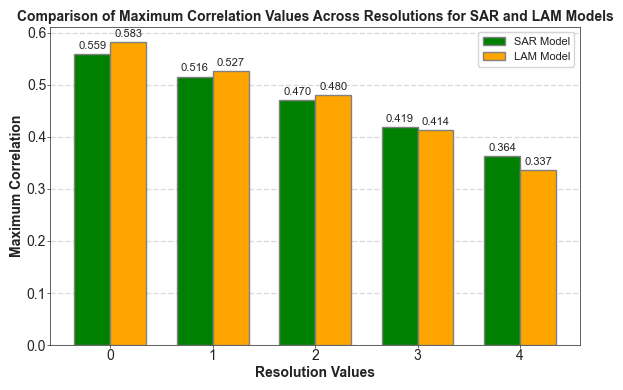

In [29]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
bar_width = 0.35
r1 = np.arange(len(resolutions))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(6, 4))

# SAR Model
plt.bar(r1, sar_correlations, color='green', width=bar_width, edgecolor='grey', label='SAR Model')

# LAM Model
plt.bar(r2, lam_correlations, color='orange', width=bar_width, edgecolor='grey', label='LAM Model')

plt.xlabel('Resolution Values', fontweight='bold')
plt.ylabel('Maximum Correlation', fontweight='bold')
plt.title('Comparison of Maximum Correlation Values Across Resolutions for SAR and LAM Models', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(resolutions))], resolutions)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding text labels
for i in range(len(sar_correlations)):
    plt.text(r1[i], sar_correlations[i] + 0.01, f"{sar_correlations[i]:.3f}", ha='center', fontsize=8)
    plt.text(r2[i], lam_correlations[i] + 0.01, f"{lam_correlations[i]:.3f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## A Comparative Analysis of Normalization Techniques and SAR/LAM Models
In this notebook, we dive into the heart of brain connectivity analysis. We will compare how different normalization techniques affect the performance of SAR and LAM models, seeking the method that yields the most meaningful insights into the brain's structure. The ultimate goal is to determine the best normalization approach for modeling the intricate web of human functional brain connectivity and provide a deeper understanding of how our brain regions communicate.

In [ ]:
# All the tools you need in this notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from yanat import core as cor
import seaborn as sns
from yanat import utils as ut
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager
from matplotlib import font_manager
from visual_config import *
for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)
set_visual_style()


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Human Connectome Dataset 

In [ ]:
data = scipy.io.loadmat("human_connectome_dataset/Consensus_Connectomes.mat",  
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,) 

Content of this dataset:

LauConsensus
  Matrices:

    [0]: Connectivity Matrix

    [1]: Fiber Lengths

    [2]: Functional Connectivity Matrix

    [3]: Coordinates
    
    [4]: Labels and Modules

In [ ]:
res_parcellation = 2 # This is a multiresolution connectome. 
sc_connectivity = data["LauConsensus"]["Matrices"][res_parcellation][0]
fc = data["LauConsensus"]["Matrices"][res_parcellation][2] 
fiber_lengths = data["LauConsensus"]["Matrices"][res_parcellation][1]
coordinates = data["LauConsensus"]["Matrices"][res_parcellation][3]
labels = data["LauConsensus"]["Matrices"][res_parcellation][4][:, 0]
fc_modules = data["LauConsensus"]["Matrices"][res_parcellation][4][:, 2]

NOTE: For now, we choose this value as res_parcellation = 2, but as you will see in the other notebook of my project, I tried to show the effect of this value on the models and the outputs they produce. 

The codes in the below just the Brute-force way to look at it as a network: (That's why it's normal if you can't make sense of the code. )

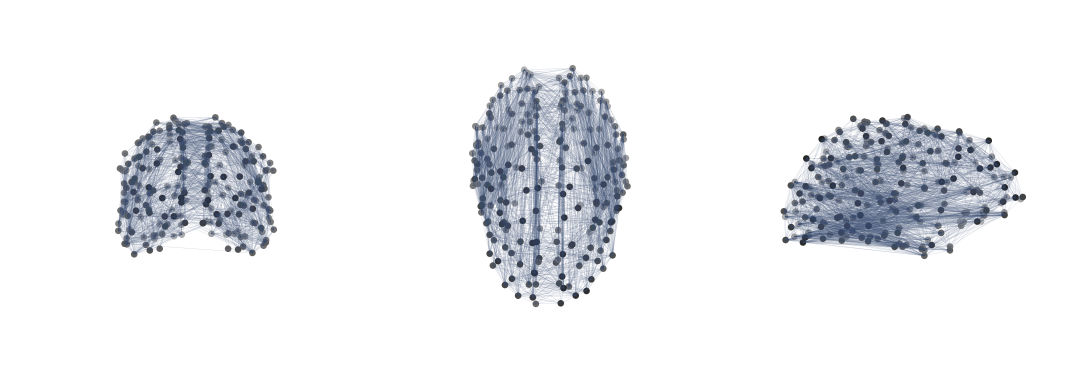

In [ ]:
SEED = 2023
sagittal = (0, 180)
axial = (90, 180) 
coronal = (0, 90)
bottom = (-90, 0)
size = 80
scatter_kw_network = dict(alpha=1, linewidths=0, edgecolors=HALF_BLACK)
scatter_kw = dict(alpha=1, linewidths=0.7, edgecolors=HALF_BLACK)
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)
for i in range(sc_connectivity.shape[0]):
    for j in range(i, sc_connectivity.shape[1]):
        if sc_connectivity[i, j] != 0:
            axes["A"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + sc_connectivity[i, j],
                linewidth=0.2,
            )
            axes["B"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + sc_connectivity[i, j],
                linewidth=0.2,
            )
            axes["C"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + sc_connectivity[i, j],
                linewidth=0.2,
            )

brain_plotter(
    np.array(coordinates[:, 0]),
    coordinates,
    axes["A"],
    view=sagittal,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
brain_plotter(
    np.flip(np.array(coordinates[:, 2])),
    coordinates,
    axes["B"],
    view=axial,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
brain_plotter(
    np.flip(np.array(coordinates[:, 1])),
    coordinates,
    axes["C"],
    view=coronal,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)

fig.tight_layout(pad=0.1)
# plt.savefig(f"results/structural_brain_network.png", dpi=600, bbox_inches="tight")

## SC matrix heatmap before the normalizations

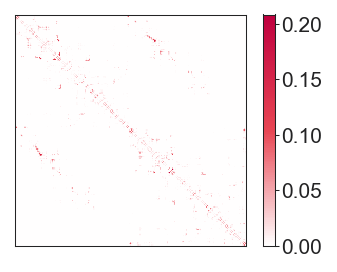

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(3, 2), dpi=150)
sns.heatmap(
    sc_connectivity,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
)
sns.despine(top=False, right=False, left=False, bottom=False)


In [ ]:
def binarizing(matrix): # This method is for the binarizing normalization, i create new for the comparasion because there were no such a method in the utils.py. 
    connectivity_binarizing = [(matrix != 0).astype(float) for matrix in matrix]
    connectivity_binarizing = np.array(connectivity_binarizing) 
    return connectivity_binarizing
# This dict is for the comparing the normalization techiniques on the sc data
normalization_methods = {
    "Log Min-Max Normalizing": ut.log_minmax_normalize(sc_connectivity),
    "Min-Max Normalizing": ut.minmax_normalize(sc_connectivity),
    "Binarizing": binarizing(sc_connectivity),
    "Spectral Normalizing": ut.spectral_normalization(1, sc_connectivity)
}

In [ ]:
# This dict will store normalized link matrices according to different normalization methods. 
# In this way, we can easily use our new matrices created with different normalization techniques in models and make comparisons. 
normalized_connectivity_matrices = {}
for method_name, normalization_function in normalization_methods.items():
    normalized_connectivity_matrices[method_name] = normalization_function
# Now we can see the new matrices which were created from normalization methods    
for method_name, matrix in normalized_connectivity_matrices.items():
    print(f"Method: {method_name}")
    print(f"Matrix:\n{matrix[:5]}\n")

Method: Log Min-Max Normalizing
Matrix:
[[0.         0.67158663 0.75218537 ... 0.         0.         0.        ]
 [0.67158663 0.         0.79916373 ... 0.         0.         0.        ]
 [0.75218537 0.79916373 0.         ... 0.         0.         0.        ]
 [0.66914935 0.71307613 0.781721   ... 0.         0.         0.        ]
 [0.26042284 0.66669361 0.62315757 ... 0.         0.         0.        ]]

Method: Min-Max Normalizing
Matrix:
[[0.00000000e+00 7.06440485e-02 1.98890737e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.06440485e-02 0.00000000e+00 3.63610181e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.98890737e-01 3.63610181e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.84670558e-02 1.20360221e-01 2.90635946e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.59593717e-04 6.63414231e-02 3.79282486e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]

Method: Binarizing
Matrix:
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 

Now, we will see the heatmaps of a human structural connectivity (SC) matrix normalized using four different normalization techniques.
these heatmaps demonstrate how different normalization techniques affect the visualization and interpretation of brain connectivity data. Log Min-Max and Binarizing seem to reveal more structure, while Min-Max and Spectral normalization result in sparser, less detailed matrices.

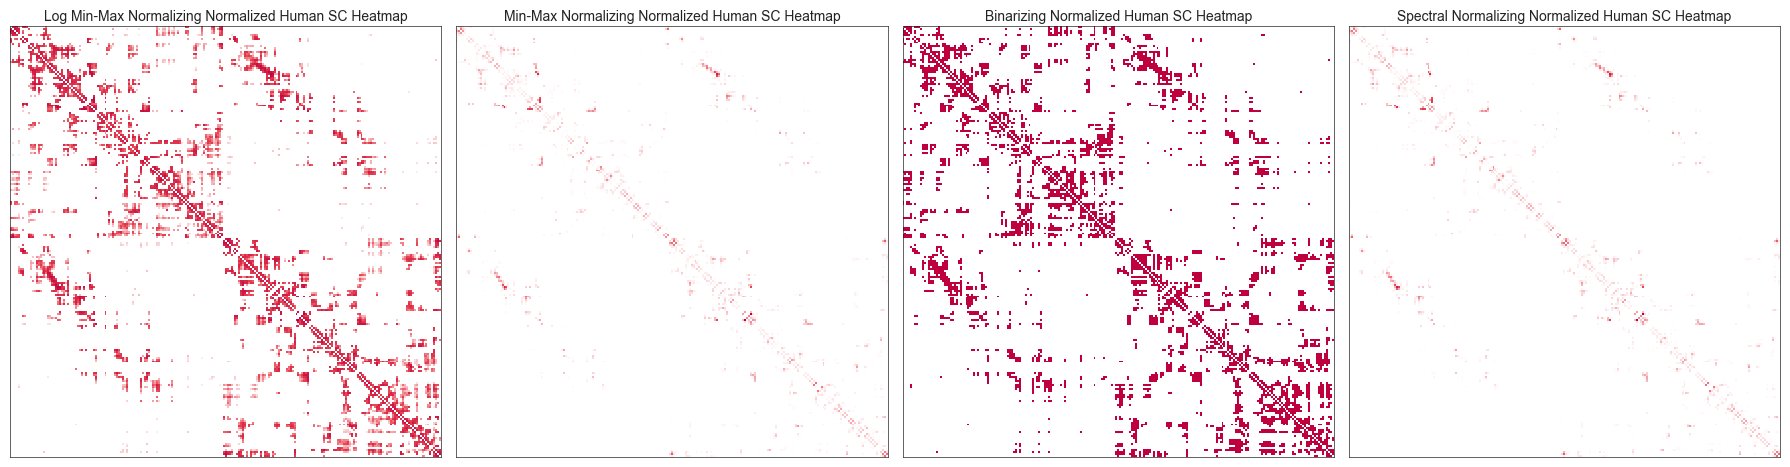

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
fig, axes = plt.subplot_mosaic([["A", "B", "C", "D"]], figsize=(20, 5), dpi=100)
for ax_key, (method_name, matrix) in zip(axes, normalized_connectivity_matrices.items()):
    normalized_matrix = matrix
    sns.heatmap(
        normalized_matrix,
        cmap=white_red_mono,  
        square=True,
        xticklabels=False,
        yticklabels=False,
        cbar=False,  
        linewidths=0,
        linecolor=HALF_BLACK,
        rasterized=True,
        ax=axes[ax_key]
    )
    axes[ax_key].title.set_text(f"{method_name} Normalized Human SC Heatmap")
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.show()

Let's look at some numerical values that can give us information about these matrices (such as intensity and spectral_radius) 

All the density values of matricies which expose differences normalized techniques are same because all normalized metrices belong the same sc matrix(The only reason for this is that normalising the SC matrix does not change the number of edges and possible edges.). However in the different res parcelation values, the densities of the merrices will be change, we will see in the next notebook. 

In [ ]:
for method_name, matrix in normalized_connectivity_matrices.items():
    normalized_matrix = matrix
    
    density = ut.find_density(normalized_matrix)
    print(f"Method: {method_name}")
    print(f"Density: {density:.4f}\n")

Method: Log Min-Max Normalizing
Density: 0.1193

Method: Min-Max Normalizing
Density: 0.1193

Method: Binarizing
Density: 0.1193

Method: Spectral Normalizing
Density: 0.1193



Let's see the spectral radius values on the different normalized SC matricies. In this way, we can comment the behaviour of a different normalized SC matricies in the dynamical system. 

In [ ]:
def calculate_spectral_radius(matrix):
    # Calculate the eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    # Calculate the spectral raidus (absulete value of the biggest eigenvalue)
    spectral_radius = max(abs(eigenvalues))
    return spectral_radius
for method_name, matrix in normalized_connectivity_matrices.items():
    normalized_matrix = matrix
    
    spectral_radius = calculate_spectral_radius(normalized_matrix)
    print(f"Method: {method_name}")
    print(f"Spectral Radius: {spectral_radius:.4f}\n")

Method: Log Min-Max Normalizing
Spectral Radius: 13.0595

Method: Min-Max Normalizing
Spectral Radius: 1.8194

Method: Binarizing
Spectral Radius: 30.5850

Method: Spectral Normalizing
Spectral Radius: 1.0000



After exploring the SC matrix, which we aim to bring closer to our target matrix, the FC matrix, along with our models, we can begin to discover which normalization technique will yield better results in our models.

## FOR SAR MODEL
Find the optimal alpha parameter for the SAR model using different normalization techniques applied to the structural connectivity (SC) matrix. By iterating through each normalization method, it runs the SAR model over a range of alpha values (from 0.01 to 1.0 for number of 500 may be you can try to number of 1000 alpha values) to find the one that yields the highest correlation with the functional connectivity (FC) matrix. 

Also, you can look at the simple_fit function which is located in the yanat library at the util.py folder. Brefiely, Simple fitting function to find the best parameters for a model. 

NOTE: This function was written for the purpose I mentioned, but it was left empty with a few parts that needed to be done. I recreated this function with the parts that need to be done and added it to the YANAT library as it is. 

In [ ]:
# Define the parameter space for the SAR model, with 500 alpha values ranging from 0.01 to 1.0.
sar_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]
best_parameters_all = {} # Initialize an empty dictionary to store the best parameters for each normalization method.
for method_name, normalized_matrix in normalization_methods.items():
    print(f"Running simple_fit for: {method_name}")
    best_parameters = ut.simple_fit(
        model=lambda **params: cor.sar(normalized_matrix, **params),
        X=fc, # # Use the functional connectivity matrix as the target.
        parameter_space=sar_parameter_space,
        n_jobs=-1
    )
    # Find the result with the highest correlation value.
    best_result = max(best_parameters, key=lambda x: x['correlation'])
    # Print the best alpha value and the highest correlation achieved for this method.
    print(f"Method: {method_name}")
    print("Best alpha:", best_result['alpha'])
    print("Best correlation:", best_result['correlation'])
    print("\n")
    # Store the best parameters and result for this normalization method in the dictionary.
    best_parameters_all[method_name] = {
        "best_parameters": best_parameters,
        "best_result": best_result
    }

Running simple_fit for: Log Min-Max Normalizing


C3PO noises: 100%|██████████| 500/500 [00:03<00:00, 139.79it/s]


Method: Log Min-Max Normalizing
Best alpha: 0.05166332665330661
Best correlation: 0.47026446372328523


Running simple_fit for: Min-Max Normalizing


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 1470.60it/s]


Method: Min-Max Normalizing
Best alpha: 0.3234669338677355
Best correlation: 0.4143847236157938


Running simple_fit for: Binarizing


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 1607.70it/s]


Method: Binarizing
Best alpha: 0.02190380761523046
Best correlation: 0.43598328633559824


Running simple_fit for: Spectral Normalizing


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 1683.50it/s]


Method: Spectral Normalizing
Best alpha: 0.5893186372745491
Best correlation: 0.4143863628539489




## Comparison of SAR Model Correlation vs Alpha Across Different Normalization Techniques
With different normalisation techniques we can easily see the behaviour of SAR model correlations on the graphs.


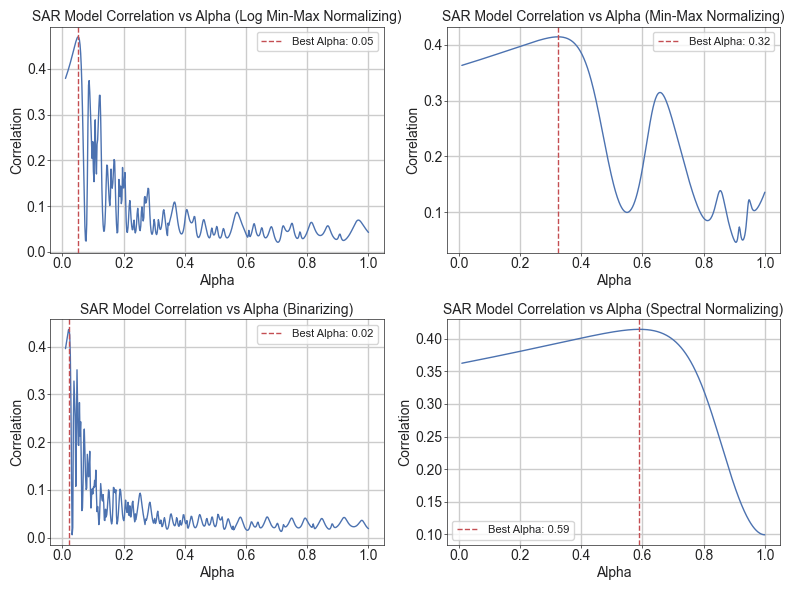

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.ravel()
for idx, (method_name, data) in enumerate(best_parameters_all.items()):
    best_parameters = data["best_parameters"]
    best_result = data["best_result"]
    alpha_values = [param['alpha'] for param in best_parameters]
    correlations = [param['correlation'] for param in best_parameters]
    ax = axes[idx]
    ax.plot(alpha_values, correlations)
    ax.set_title(f'SAR Model Correlation vs Alpha ({method_name})')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Correlation')
    ax.axvline(best_result['alpha'], color='r', linestyle='--', label=f"Best Alpha: {best_result['alpha']:.2f}")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

We can now see which normalization technique has the best correlation value (sar model)

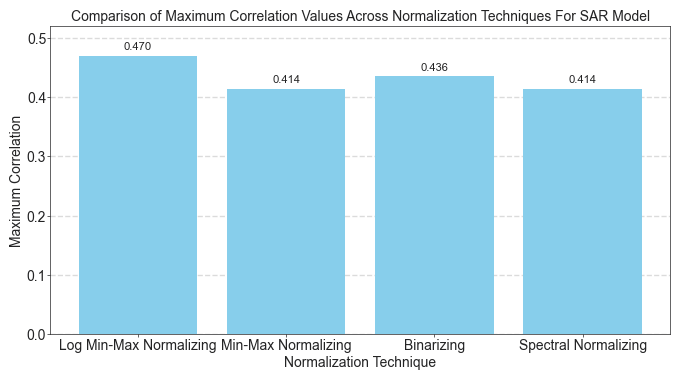

In [ ]:
normalization_methods_for_sar = list(best_parameters_all.keys())
best_correlations = [data['best_result']['correlation'] for data in best_parameters_all.values()]
plt.figure(figsize=(8, 4))
plt.bar(normalization_methods_for_sar, best_correlations, color='skyblue')
plt.title("Comparison of Maximum Correlation Values Across Normalization Techniques For SAR Model")
plt.xlabel("Normalization Technique")
plt.ylabel("Maximum Correlation")
plt.ylim(0, max(best_correlations) + 0.05)  
for i, value in enumerate(best_correlations):
    plt.text(i, value + 0.01, f"{value:.3f}", ha='center', fontsize=8)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


After these analyses , now we can choose normalizing technique for reaching the best alpha value for our SAR model. It is the Log_Min_Max normalizing. 
After the chosen normalization technique, model generate a new FC matrix. 

NOTE: If you want to see how the matrix is generated, you can look at the mathematical calculations in the function in the core.py module in YANAT. 

In [ ]:
connectivity_log_min_max_normalize = normalized_connectivity_matrices["Log Min-Max Normalizing"]
log_min_max_best_result = best_parameters_all["Log Min-Max Normalizing"]['best_result']
log_min_max_best_alpha = log_min_max_best_result['alpha']
sar = cor.sar(connectivity_log_min_max_normalize, alpha=log_min_max_best_alpha)
sar #This is the matrix which is produced by using the SC matrix

array([[1.06071688, 0.11992019, 0.12642712, ..., 0.01075569, 0.00715173,
        0.00446662],
       [0.11992019, 1.06671929, 0.13289008, ..., 0.01463561, 0.00909184,
        0.00639565],
       [0.12642712, 0.13289008, 1.05475437, ..., 0.01162374, 0.00741   ,
        0.00474478],
       ...,
       [0.01075569, 0.01463561, 0.01162374, ..., 1.22009461, 0.24859115,
        0.18435009],
       [0.00715173, 0.00909184, 0.00741   , ..., 0.24859115, 1.15464536,
        0.17599268],
       [0.00446662, 0.00639565, 0.00474478, ..., 0.18435009, 0.17599268,
        1.0979607 ]])

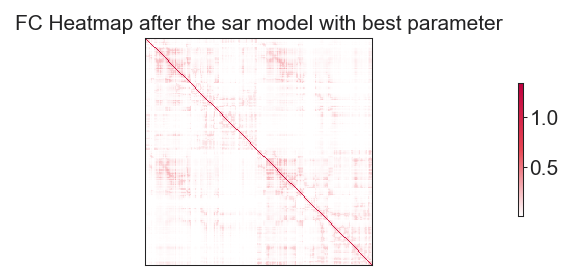

In [ ]:
fig, axes = plt.subplot_mosaic([["A"]], figsize=SMALL, dpi=150)
cbar_ax = fig.add_axes([1.00, 0.275, 0.01, 0.45])
sns.heatmap(
    sar,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=True, 
    cbar_ax=cbar_ax,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["A"]
)
axes["A"].title.set_text("FC Heatmap after the sar model with best parameter")
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

## FOR LAM MODEL 
Find the optimal alpha parameter for the LAM model using different normalization techniques applied to the structural connectivity (SC) matrix. By iterating through each normalization method, it runs the LAM model over a range of alpha values (from 0.01 to 1.0 for number of 500 may be you can try to number of 1000 alpha values) to find the one that yields the highest correlation with the functional connectivity (FC) matrix. 

In [ ]:
# Exactly the same as we did for the SAR model 
lam_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]
best_parameters_all_lam = {}

for method_name_lam, normalized_matrix_lam in normalized_connectivity_matrices.items():
    print(f"Running simple_fit for: {method_name_lam} with LAM model")
    
    best_parameters_lam = ut.simple_fit(
        model=lambda **params: cor.lam(normalized_matrix_lam, **params),
        X=fc,
        parameter_space=lam_parameter_space,
        n_jobs=-1
    )
    
    best_result_lam = max(best_parameters_lam, key=lambda x: x['correlation'])
    
    print(f"Method: {method_name_lam}")
    print("Best alpha:", best_result_lam['alpha'])
    print("Best correlation:", best_result_lam['correlation'])
    print("\n")
   
    best_parameters_all_lam[method_name_lam] = {
        "best_parameters": best_parameters_lam,
        "best_result": best_result_lam
    }


Running simple_fit for: Log Min-Max Normalizing with LAM model


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 734.66it/s]


Method: Log Min-Max Normalizing
Best alpha: 0.08935871743486974
Best correlation: 0.4804107070510337


Running simple_fit for: Min-Max Normalizing with LAM model


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 1923.09it/s]


Method: Min-Max Normalizing
Best alpha: 0.4464729458917836
Best correlation: 0.4041901439332558


Running simple_fit for: Binarizing with LAM model


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 1396.65it/s]


Method: Binarizing
Best alpha: 0.03777555110220441
Best correlation: 0.45740774151299207


Running simple_fit for: Spectral Normalizing with LAM model


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 1376.55it/s]


Method: Spectral Normalizing
Best alpha: 0.8115230460921844
Best correlation: 0.4041916983946403




## Comparison of LAM Model Correlation vs Alpha Across Different Normalization Techniques

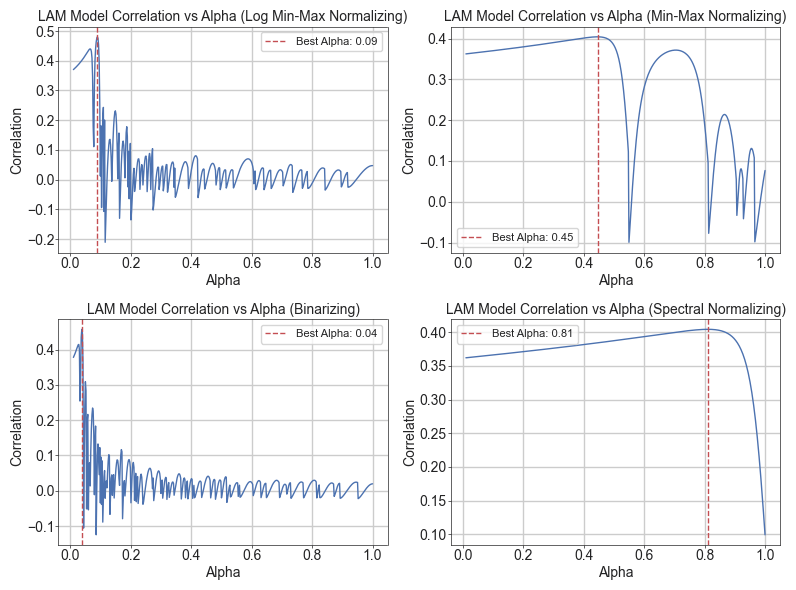

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.ravel()

for idx_lam, (method_name_lam, data_lam) in enumerate(best_parameters_all_lam.items()):
    best_parameters_lam = data_lam["best_parameters"]
    best_result_lam = data_lam["best_result"]
    alpha_values_lam = [param['alpha'] for param in best_parameters_lam]
    correlations_lam = [param['correlation'] for param in best_parameters_lam]
    
    ax_lam = axes[idx_lam]
    ax_lam.plot(alpha_values_lam, correlations_lam)
    ax_lam.set_title(f'LAM Model Correlation vs Alpha ({method_name_lam})')
    ax_lam.set_xlabel('Alpha')
    ax_lam.set_ylabel('Correlation')
    ax_lam.axvline(best_result_lam['alpha'], color='r', linestyle='--', label=f"Best Alpha: {best_result_lam['alpha']:.2f}")
    ax_lam.legend()
    ax_lam.grid(True)

plt.tight_layout()
plt.show()

We can now see which normalization technique has the best correlation value (LAM model)


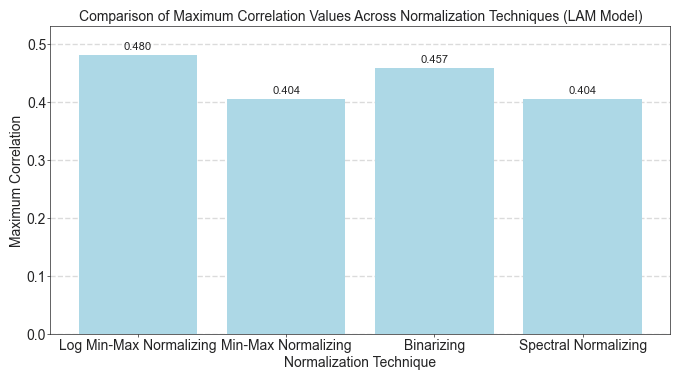

In [ ]:
normalization_methods_for_lam = list(best_parameters_all_lam.keys())
best_correlations_lam = [data_lam['best_result']['correlation'] for data_lam in best_parameters_all_lam.values()]

plt.figure(figsize=(8, 4))
plt.bar(normalization_methods_for_lam, best_correlations_lam, color='lightblue')
plt.title("Comparison of Maximum Correlation Values Across Normalization Techniques (LAM Model)")
plt.xlabel("Normalization Technique")
plt.ylabel("Maximum Correlation")
plt.ylim(0, max(best_correlations_lam) + 0.05)  

for i, value in enumerate(best_correlations_lam):
    plt.text(i, value + 0.01, f"{value:.3f}", ha='center', fontsize=8)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see the best correlation value for the LAM model, so we will choose the again log_min_max normalizing to close the our target matrix for LAM model. 

In [ ]:
log_min_max_best_result_forlam = best_parameters_all_lam["Log Min-Max Normalizing"]['best_result']
log_min_max_best_alpha_forlam = log_min_max_best_result_forlam['alpha']
lam = cor.lam(connectivity_log_min_max_normalize, alpha=log_min_max_best_alpha_forlam)
lam # Hmm, we can see the negative values(i think it is quite normal)

array([[ 1.09248093,  0.14418776,  0.14739478, ..., -0.01908226,
        -0.02144165, -0.03149905],
       [ 0.14418776,  1.10273891,  0.15525963, ..., -0.02492558,
        -0.02763704, -0.03689515],
       [ 0.14739478,  0.15525963,  1.08596864, ..., -0.01566398,
        -0.01944277, -0.03020593],
       ...,
       [-0.01908226, -0.02492558, -0.01566398, ...,  1.2102511 ,
         0.22059245,  0.09903786],
       [-0.02144165, -0.02763704, -0.01944277, ...,  0.22059245,
         1.13761265,  0.10737011],
       [-0.03149905, -0.03689515, -0.03020593, ...,  0.09903786,
         0.10737011,  1.03974479]])

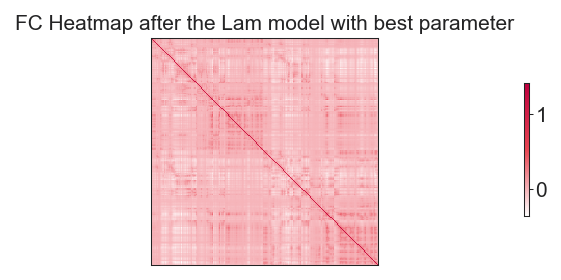

In [ ]:
fig, axes = plt.subplot_mosaic([["A"]], figsize=SMALL, dpi=150)
cbar_ax = fig.add_axes([1.00, 0.275, 0.01, 0.45])
sns.heatmap(
    lam,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=True, 
    cbar_ax=cbar_ax,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["A"]
)
axes["A"].title.set_text("FC Heatmap after the Lam model with best parameter")
sns.despine(fig=fig, top=False, right=False, left=False,bottom=False)

## Barplot combining SAR and LAM, so that we can show which of these models gives better results for different normalization techniques.

In [ ]:
normalization_techniques = list(best_parameters_all.keys())
best_correlations_sar = [data['best_result']['correlation'] for data in best_parameters_all.values()]
best_correlations_lam = [data_lam['best_result']['correlation'] for data_lam in best_parameters_all_lam.values()]

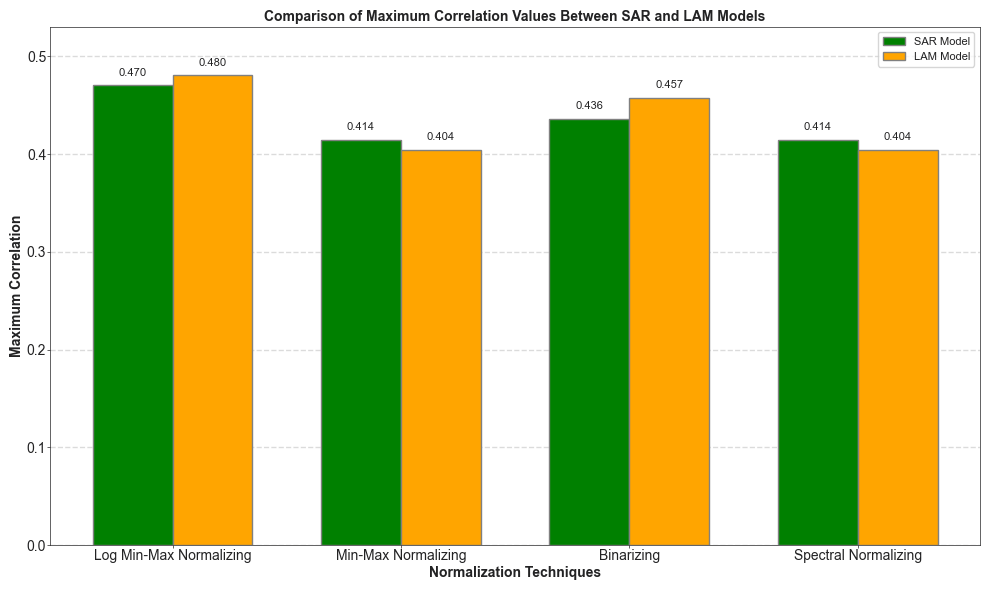

In [ ]:
bar_width = 0.35
r1 = np.arange(len(normalization_techniques))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))
# We already have the best correlation values for both SAR and LAM models for different normalization techniques.
plt.bar(r1, best_correlations_sar, color='green', width=bar_width, edgecolor='grey', label='SAR Model')
plt.bar(r2, best_correlations_lam, color='orange', width=bar_width, edgecolor='grey', label='LAM Model')

plt.xlabel('Normalization Techniques', fontweight='bold')
plt.ylabel('Maximum Correlation', fontweight='bold')
plt.title('Comparison of Maximum Correlation Values Between SAR and LAM Models', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(normalization_techniques))], normalization_techniques)
plt.ylim(0, max(max(best_correlations_sar), max(best_correlations_lam)) + 0.05)

plt.legend()

for i in range(len(best_correlations_sar)):
    plt.text(r1[i], best_correlations_sar[i] + 0.01, f"{best_correlations_sar[i]:.3f}", ha='center', fontsize=8)
    plt.text(r2[i], best_correlations_lam[i] + 0.01, f"{best_correlations_lam[i]:.3f}", ha='center', fontsize=8)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Finally, we see the which model's conclusion matrix is close to target matrix(HUMAN FC). 

## "FC Heatmap after the LAM model with best parameter(with log_min_max normalize)" is close to our target matrix 

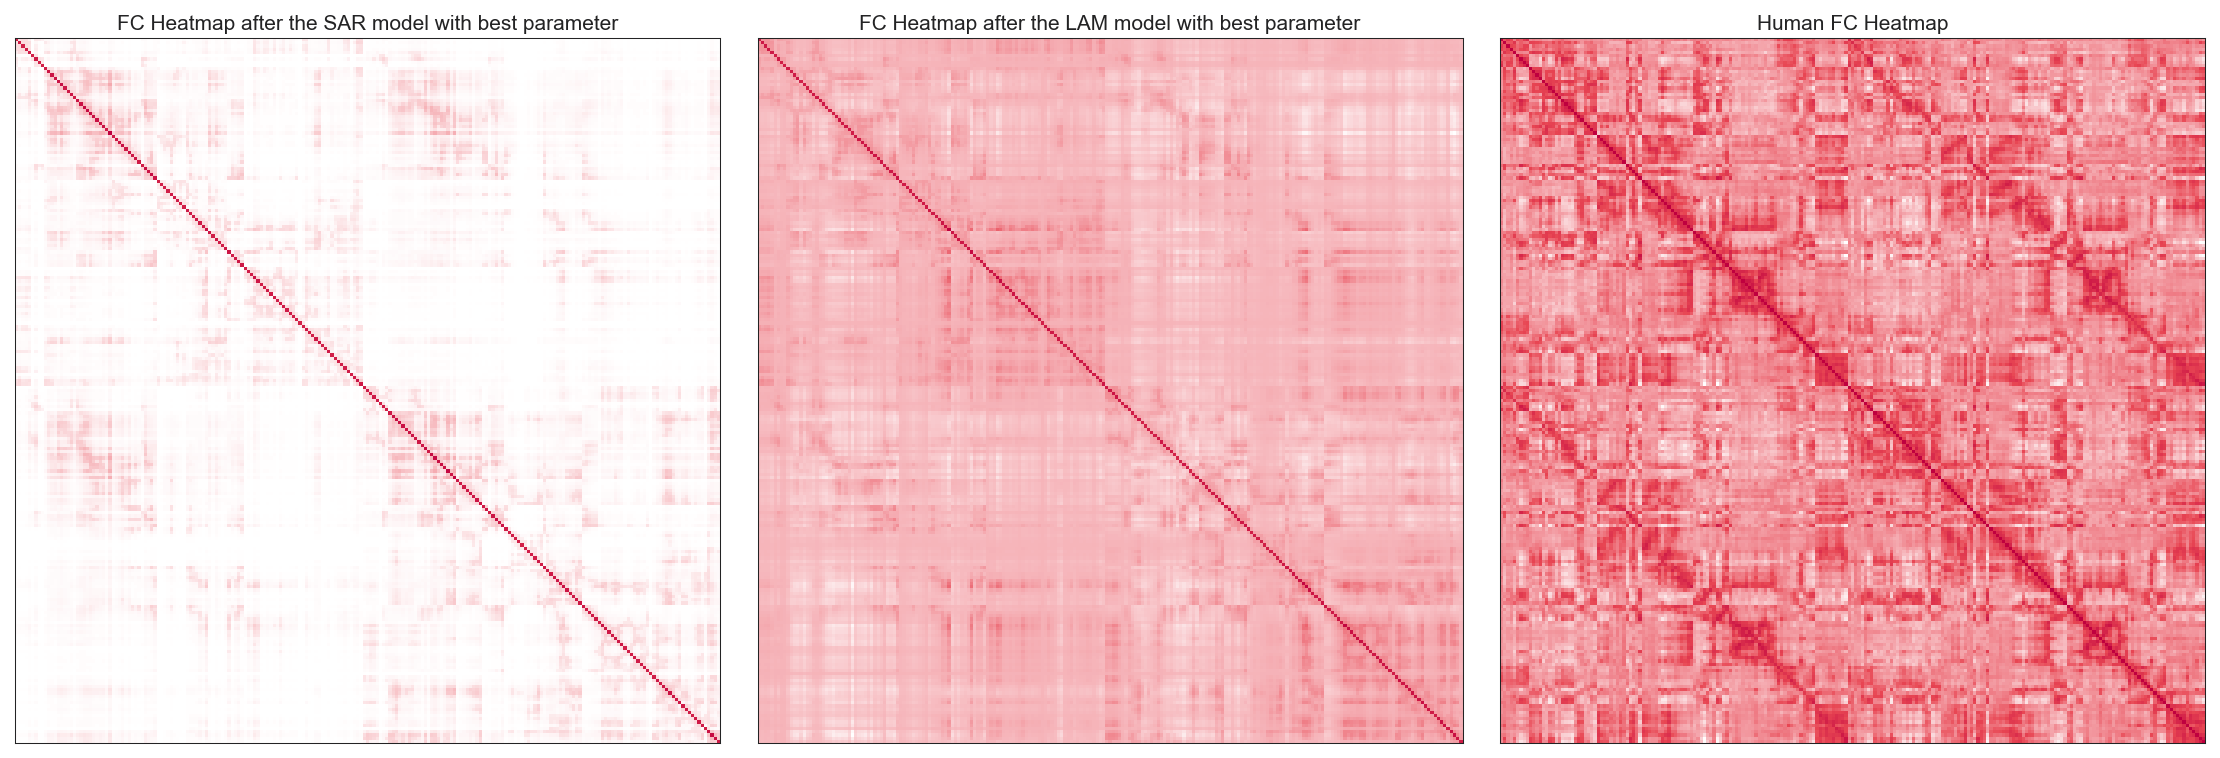

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# SAR Model heatmap
sns.heatmap(
    sar,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes[0]
)
axes[0].set_title("FC Heatmap after the SAR model with best parameter")
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

# LAM Model heatmap
sns.heatmap(
    lam,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False, 
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes[1]
)
axes[1].set_title("FC Heatmap after the LAM model with best parameter")
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

# Original FC heatmap (Target Heatmap)
sns.heatmap(
    fc,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,  
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes[2]
)
axes[2].set_title("Human FC Heatmap")
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

plt.tight_layout()
plt.show()

And we can see how the correlation changes according to res values(for both SAR and LAM model)

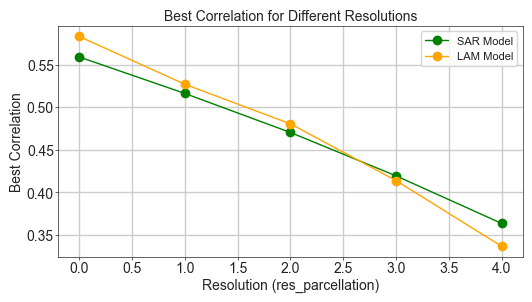

In [30]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
resolutions = list(best_parameters_all_res.keys())
sar_correlations = [data['best_result']['correlation'] for data in best_parameters_all_res.values()]
lam_correlations = [data['best_result']['correlation'] for data in best_parameters_all_lam_res.values()]

# Plot SAR Model Correlation vs Resolution
plt.figure(figsize=(6, 3))
plt.plot(resolutions, sar_correlations, marker='o', linestyle='-', color='green', label='SAR Model')
plt.plot(resolutions, lam_correlations, marker='o', linestyle='-', color='orange', label='LAM Model')
plt.xlabel('Resolution (res_parcellation)')
plt.ylabel('Best Correlation')
plt.title('Best Correlation for Different Resolutions')
plt.legend()
plt.grid(True)
plt.show()

We can easily see that the best correlation for both SAR and LAM model is with ‘res_parcellation = 0’, so we will use res value = 0 and apply our LAM model.  

In [31]:
res_parcellation = 0
fc = data["LauConsensus"]["Matrices"][res_parcellation][2] 
connectivity = data["LauConsensus"]["Matrices"][res_parcellation][0]

In [32]:
connectivity_log_min_max_normalize = ut.log_minmax_normalize(connectivity)

In [33]:
lam_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]

best_parameters_forlam = ut.simple_fit(
    model=lambda **params: cor.lam(connectivity_log_min_max_normalize, **params),
    X=fc,
    parameter_space=lam_parameter_space,
    n_jobs=-1
)


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 4504.41it/s]


In [34]:
best_result_forlam = max(best_parameters_forlam, key=lambda x: x['correlation']) 
print("Best parameters:", best_result_forlam['alpha'])
print("Best correlation:", best_result_forlam['correlation'])

Best parameters: 0.12110220440881762
Best correlation: 0.5829481747524999


In [35]:
lam = cor.lam(connectivity_log_min_max_normalize, alpha=best_result_forlam['alpha']) 
lam

array([[ 1.09556925,  0.1354627 ,  0.05297222, ..., -0.16275883,
        -0.05167756, -0.21023853],
       [ 0.1354627 ,  1.05195703, -0.00307928, ..., -0.12858995,
        -0.04081914, -0.1651858 ],
       [ 0.05297222, -0.00307928,  1.02080546, ..., -0.05550843,
        -0.01997871, -0.06243259],
       ...,
       [-0.16275883, -0.12858995, -0.05550843, ...,  1.07008761,
         0.09262862,  0.10404819],
       [-0.05167756, -0.04081914, -0.01997871, ...,  0.09262862,
         1.02013564,  0.07014553],
       [-0.21023853, -0.1651858 , -0.06243259, ...,  0.10404819,
         0.07014553,  1.00167904]])

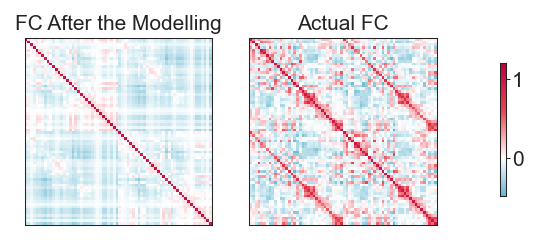

In [36]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)
cbar_ax = fig.add_axes([1.02, 0.275, 0.01, 0.45])
sns.heatmap(
    lam,
    square=True,
    center=0,
    cmap=diverge_from_white,
    cbar=True,
    cbar_ax=cbar_ax,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
    ax = axes["A"],
    vmax=1.2 
)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    cbar = True,
    cbar_ax=cbar_ax,
    yticklabels=False,
    xticklabels=False,
    ax = axes["B"],
    vmax=1.2 
)
axes["A"].title.set_text("FC After the Modelling")
axes["B"].title.set_text("Actual FC")
sns.despine(fig=fig, top=False, right=False, left=False,bottom=False)